In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import random
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [2]:
#Read dataset
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')
X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

#add location to each sample
train_a["location"] = "A"
train_b["location"] = "B"
train_c["location"] = "C"
X_train_estimated_a["location"] = "A"
X_train_estimated_b["location"] = "B"
X_train_estimated_c["location"] = "C"
X_train_observed_a["location"] = "A"
X_train_observed_b["location"] = "B"
X_train_observed_c["location"] = "C"
X_test_estimated_a["location"] = "A"
X_test_estimated_b["location"] = "B"
X_test_estimated_c["location"] = "C"


def fill_last(frame):
    copy = frame.copy()
    
    copy["date_forecast"] = copy["date_forecast"] + pd.Timedelta(minutes=15)
    
    copy = copy[copy["date_forecast"].apply(lambda time : time.hour == 0 and time.minute == 0)]
    
    frame = pd.concat([
        frame,
        copy.astype(frame.dtypes)
    ])
    return frame.drop_duplicates(subset="date_forecast", keep="first")

X_test_estimated_a = fill_last(X_test_estimated_a)
X_test_estimated_b = fill_last(X_test_estimated_b)
X_test_estimated_c = fill_last(X_test_estimated_c)

#remove extra minute 00 sample
X_train_observed_a = X_train_observed_a.iloc[:-1,:]
X_train_observed_b = X_train_observed_b.iloc[:-1,:]
X_train_observed_c = X_train_observed_c.iloc[:-1,:]

#add date_calc column same as date_forecast column to observed data
X_train_observed_a.insert(0, "date_calc", X_train_observed_a["date_forecast"])
X_train_observed_b.insert(0, "date_calc", X_train_observed_b["date_forecast"])
X_train_observed_c.insert(0, "date_calc", X_train_observed_c["date_forecast"])

#concat all the samples and remove date_calc column
X_train_raw = pd.concat([X_train_observed_a,
                     X_train_observed_b,
                     X_train_observed_c,
                     X_train_estimated_a,
                     X_train_estimated_b,
                     X_train_estimated_c,
                     X_test_estimated_a,
                     X_test_estimated_b,
                     X_test_estimated_c])


#### BYRKJ START ####
print(train_b.shape)

#remove some weird artifacts from train_b target values
train_b = pd.concat([train_b[:19140], train_b[20142:]])
print(train_b.shape)
train_b["rolling"] = train_b["pv_measurement"].rolling(4).mean()
print(train_b.shape)
train_b["keep"] = train_b["pv_measurement"] - train_b["rolling"] != 0 + train_b["pv_measurement"].apply(lambda a: a==0)
print(train_b.shape)
train_b = train_b[train_b["keep"]]
print(train_b.shape)
train_b = train_b.iloc[:,:3]
print(train_b.shape)

# Calculate the difference between consecutive measurements
# data_B = train_b.copy()
# data_B['diff'] = data_B['pv_measurement'].diff()

# # Identify intervals where the difference is zero and the measurement is not 0.0
# constant_intervals_B = data_B[(data_B['diff'] == 0) & (data_B['pv_measurement'] != 0) & (data_B['pv_measurement'].notna())]

# # Group these intervals and count their lengths
# grouped_intervals_B = (constant_intervals_B
#                        .assign(group=(constant_intervals_B['time'].diff() != pd.Timedelta(hours=1)).cumsum())
#                        .groupby('group')
#                        .agg(start_time=('time', 'first'), end_time=('time', 'last'), count=('time', 'count'), constant_value=('pv_measurement', 'first'))
#                        .reset_index(drop=True))

# # Filter out short intervals (e.g., less than 3 hours) as they might not be considered "broken"
# long_constant_intervals_B = grouped_intervals_B[grouped_intervals_B['count'] >= 3]

# def replace_with_values_from_C(data_B, data_C, constant_intervals):
#     data_B_copy = data_B.copy()
#     """
#     Replace values in dataset B's constant intervals with corresponding values from dataset C.

#     :param data_B: DataFrame for dataset B.
#     :param data_C: DataFrame for dataset C.
#     :param constant_intervals: DataFrame with constant intervals in B to be replaced.
#     :return: Modified dataset B with values replaced from C.
#     """
#     for index, row in constant_intervals.iterrows():
#         start_time, end_time = row['start_time'], row['end_time']

#         # Iterate through each timestamp within the interval
#         for time in pd.date_range(start=start_time, end=end_time, freq='H'):
#             # Check if there's a corresponding timestamp in C
#             if time in data_C['time'].values:
#                 # Replace the value in B with the value from C
#                 value_C = data_C.loc[data_C['time'] == time, 'pv_measurement'].values[0]
#                 data_B_copy.loc[data_B_copy['time'] == time, 'pv_measurement'] = value_C

#     # Replace the constant 0.0 values from line 19140 to 20143 in dataset B with the values from the same timestamp in dataset C.

#     # Iterate through each timestamp within the interval
#     for time in pd.date_range(start='2021-03-08 15:00:00', end='2021-04-19 11:00:00', freq='H'):
#         # Check if there's a corresponding timestamp in C
#         if time in data_C['time'].values:
#             # Replace the value in B with the value from C
#             value_C = data_C.loc[data_C['time'] == time, 'pv_measurement'].values[0]
#             data_B_copy.loc[data_B_copy['time'] == time, 'pv_measurement'] = value_C


#     return data_B_copy

# # Replace values in dataset B using dataset C for the identified constant intervals
# train_B_modified = replace_with_values_from_C(data_B, train_c, long_constant_intervals_B)

# # Drop the diff column
# train_B_modified = train_B_modified.drop(columns=['diff'])

# fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
# axs[0].plot(train_B_modified['time'], train_B_modified['pv_measurement'])
# axs[0].set_title('Dataset B (Modified)')
# axs[1].plot(train_c['time'], train_c['pv_measurement'])
# axs[1].set_title('Dataset C')
# axs[2].plot(train_b['time'], train_b['pv_measurement'])
# axs[2].set_title('Dataset B')
# plt.show()

#### BYRKJ END ####


parse_dates = ['time']
X_test_targets = pd.read_csv("test.csv", parse_dates=parse_dates)
display(X_test_targets)

train_a["id"] = -10
train_b["id"] = -10
train_c["id"] = -10

X_test_targets = X_test_targets.rename(columns = {"prediction" : "pv_measurement"})

targets = pd.concat([train_a,
                     train_b,
                     train_c,
                     X_test_targets.astype(train_a.dtypes)]).dropna()

#X_train_raw["date_forecast"] = X_train_raw["date_forecast"] + pd.Timedelta(minutes=-60)

features00 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 0)].copy()
features00["merge_time"] = features00["date_forecast"]


features15 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 15)].copy()
features15["merge_time"] = features15["date_forecast"] + pd.Timedelta(minutes=-15)


features30 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 30)].copy()
features30["merge_time"] = features30["date_forecast"] + pd.Timedelta(minutes=-30)


features45 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 45)].copy()
features45["merge_time"] = features45["date_forecast"] + pd.Timedelta(minutes=-45)


X_train_raw["date_forecast"] = X_train_raw["date_forecast"] + pd.Timedelta(minutes = -60)
features60 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 00)].copy()
features60["merge_time"] = features60["date_forecast"]

dataset = targets
dataset = dataset.rename(columns={"time": "merge_time"})

#averages the features meassured at target time +00, +15, +30, +45 and +60
def add_feature_average_00_60(dataset, f00, f15, f30, f45, f60, column_name):
    dataset = pd.merge(
        left=dataset,
        right = f00[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner")
    dataset = pd.merge(
        left=dataset,
        right = f15[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_15"])
    dataset = pd.merge(
        left=dataset,
        right = f30[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_30"])
    dataset = pd.merge(
        left=dataset,
        right = f45[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_45"])
    dataset = pd.merge(
        left=dataset,
        right = f60[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_60"])


    dataset[column_name] = (dataset[column_name] +
                            dataset[column_name + "_15"] +
                            dataset[column_name + "_30"] +
                            dataset[column_name + "_45"] +
                            dataset[column_name + "_60"])/5
    dataset = dataset.drop([column_name + "_15",
                            column_name + "_30",
                            column_name + "_45",
                            column_name + "_60"],
                           axis=1)

    return dataset

#adds a single feature from one observation
def add_feature(dataset, f, column_name):
  return pd.merge(
        left=dataset,
        right=f[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner"
  )

#adds an One Hot Encoding of the column to the dataset
def OHE(dataset, f, column_name, suffix=""):

    dataset = pd.merge(
        left=dataset,
        right = f[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner")

    values = dataset[column_name].unique()

    for value in values:
        dataset[column_name + "_" + suffix + str(value)] = dataset[column_name].apply(lambda a : a == value).map({True: 1, False: 0})

    dataset = dataset.drop([column_name], axis=1)
    return dataset

def OHE_all(dataset, f00, f15, f30, f45, f60, column_name):
    dataset = OHE(dataset, f00, column_name, suffix="00_")
    dataset = OHE(dataset, f15, column_name, suffix="15_")
    dataset = OHE(dataset, f30, column_name, suffix="30_")
    dataset = OHE(dataset, f45, column_name, suffix="45_")
    dataset = OHE(dataset, f60, column_name, suffix="60_")

    return dataset

#adds all observations
def add_all(dataset, f00, f15, f30, f45, f60, column_name):
    dataset[column_name + "_00"] = add_feature(dataset, f00, column_name)[column_name]
    dataset[column_name + "_15"] = add_feature(dataset, f15, column_name)[column_name]
    dataset[column_name + "_30"] = add_feature(dataset, f30, column_name)[column_name]
    dataset[column_name + "_45"] = add_feature(dataset, f45, column_name)[column_name]
    dataset[column_name + "_60"] = add_feature(dataset, f60, column_name)[column_name]

    return dataset

#gjennomsnitt fordi verdien er trolig momentan og varierer lite
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "absolute_humidity_2m:gm3")

#gjennomsnitt fordi verdien er trolig momentan og varierer lite
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "air_density_2m:kgm3")

#tar verdien fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "clear_sky_energy_1h:J")

#gjennomsnitt fordi verdien er momentan og varierer lite
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "clear_sky_rad:W")

#OHE av kategorisk variabel #!Opp til diskusjon om man skal ta gjennomsnitt eller flere av målingene
dataset = OHE(dataset, features60, "dew_or_rime:idx")

#gjennomsnitt fordi verdien er trolig momentan
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "dew_point_2m:K")

#gjennomsnitt fordi verdien er momentan
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "diffuse_rad:W")

#tar verdi fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "diffuse_rad_1h:J")

#gjennomsnitt fordi verdien er momentan
dataset = add_feature(dataset, features60, "direct_rad:W")#!Try without

#tar verdi fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "direct_rad_1h:J")#!Try without

#gjennomsnitt fordi verdien er trolig momentan
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "effective_cloud_cover:p")

#tar verdi fra +60 siden den viser måling mellom 00 og 60, #!kan det være gunstig å ha med 3h, 6h, 12h, 24h????
dataset = add_feature(dataset, features60, "fresh_snow_1h:cm")

#tar alle verdiene siden disse nok er ekstremt viktige for modellen
dataset = add_all(dataset, features00, features15, features30, features45, features60, "is_day:idx")

#tar alle verdiene siden disse nok er ekstremt viktige for modellen
dataset = add_all(dataset, features00, features15, features30, features45, features60, "is_in_shadow:idx")

#tar gjennomsnittet siden jeg vet ikke +++ #!jeg tar kun med en type måling for trykk, raw data inneholder 4 forskjellige mulig at flere er relevante
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "msl_pressure:hPa")

#tar alle verdier siden måleintervallet er så kort
dataset = add_all(dataset, features00, features15, features30, features45, features60, "precip_5min:mm")
dataset = OHE_all(dataset, features00, features15, features30, features45, features60, "precip_type_5min:idx")

#tar gjennomsnitt fordi jeg vet ikke #!diskuter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "prob_rime:p")

#tar gjennomsnitt fordi jeg vet ikke #!diskuter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "relative_humidity_1000hPa:p")

#OHE because value is binary
dataset = OHE(dataset, features60, "snow_density:kgm3")

#disse tar jeg bare gjennomsnittet av
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_depth:cm")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_drift:idx")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_melt_10min:mm")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_water:kgm2")

#legger til alle siden har testing har vist at disse er svært viktige
dataset = add_all(dataset, features00, features15, features30, features45, features60, "sun_azimuth:d")
dataset = add_all(dataset, features00, features15, features30, features45, features60, "sun_elevation:d")

#gjennomsnitt siden variasjonen hvert kvarter sannsynligvis
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "t_1000hPa:K")

#gjennomsnitt fordi jeg vet ikke
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "total_cloud_cover:p")

#gjennomsnitt fordi jeg vet ikke
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "visibility:m")

#Gjennomsnitt fordi lite variabel
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_u_10m:ms")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_v_10m:ms")

#OHE av location
dataset["location_A"] = dataset["location"].apply(lambda loc: loc == "A").map({True: 1, False: 0})
dataset["location_B"] = dataset["location"].apply(lambda loc: loc == "B").map({True: 1, False: 0})
dataset["location_C"] = dataset["location"].apply(lambda loc: loc == "C").map({True: 1, False: 0})

#dataset["day"] = dataset["merge_time"].apply(lambda a : a.day_of_year)
#dataset["hour"] = dataset["merge_time"].apply(lambda a : a.hour)

display(dataset)

(32848, 3)
(31846, 3)
(31846, 4)
(31846, 5)
(28708, 5)
(28708, 3)


,id,time,prediction,location
0,0,2023-05-01 00:00:00,0,A
1,1,2023-05-01 01:00:00,0,A
2,2,2023-05-01 02:00:00,0,A
3,3,2023-05-01 03:00:00,0,A
4,4,2023-05-01 04:00:00,0,A
...,...,...,...,...
2155,2155,2023-07-03 19:00:00,0,C
2156,2156,2023-07-03 20:00:00,0,C
2157,2157,2023-07-03 21:00:00,0,C
2158,2158,2023-07-03 22:00:00,0,C


,merge_time,pv_measurement,location,id,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx_0.0,dew_or_rime:idx_1.0,dew_or_rime:idx_-1.0,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,fresh_snow_1h:cm,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,is_in_shadow:idx_00,is_in_shadow:idx_15,is_in_shadow:idx_30,is_in_shadow:idx_45,is_in_shadow:idx_60,msl_pressure:hPa,precip_5min:mm_00,precip_5min:mm_15,precip_5min:mm_30,precip_5min:mm_45,precip_5min:mm_60,precip_type_5min:idx_00_0.0,precip_type_5min:idx_00_1.0,precip_type_5min:idx_00_3.0,precip_type_5min:idx_00_2.0,precip_type_5min:idx_00_6.0,precip_type_5min:idx_00_5.0,precip_type_5min:idx_00_4.0,precip_type_5min:idx_15_0.0,precip_type_5min:idx_15_1.0,precip_type_5min:idx_15_3.0,precip_type_5min:idx_15_2.0,precip_type_5min:idx_15_4.0,precip_type_5min:idx_15_5.0,precip_type_5min:idx_30_0.0,precip_type_5min:idx_30_1.0,precip_type_5min:idx_30_3.0,precip_type_5min:idx_30_2.0,precip_type_5min:idx_30_5.0,precip_type_5min:idx_45_0.0,precip_type_5min:idx_45_1.0,precip_type_5min:idx_45_3.0,precip_type_5min:idx_45_2.0,precip_type_5min:idx_45_6.0,precip_type_5min:idx_45_5.0,precip_type_5min:idx_45_4.0,precip_type_5min:idx_60_0.0,precip_type_5min:idx_60_1.0,precip_type_5min:idx_60_3.0,precip_type_5min:idx_60_2.0,precip_type_5min:idx_60_6.0,precip_type_5min:idx_60_5.0,precip_type_5min:idx_60_4.0,prob_rime:p,relative_humidity_1000hPa:p,snow_density:kgm3_nan,snow_density:kgm3_250.0,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_u_10m:ms,wind_speed_v_10m:ms,location_A,location_B,location_C
0,2019-06-02 22:00:00,0.00,A,-10,7.700000,1.2276,0.000000,0.000000,1,0,0,280.299988,0.000000,0.000000,0.0,0.000000,99.180000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1006.140015,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,71.179993,0,0,0.0,0.0,-0.0,0.18,342.834015,346.294006,349.768005,353.251007,356.742004,-3.202,-3.650,-3.998,-4.247,-4.393,286.339996,100.000000,40649.164062,-3.56,-0.40,1,0,0
1,2019-06-02 23:00:00,0.00,A,-10,7.700000,1.2230,0.000000,0.000000,1,0,0,280.279968,0.000000,0.000000,0.0,0.000000,99.799995,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1005.079956,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,67.599998,0,0,0.0,0.0,-0.0,0.20,356.742004,0.235000,3.728000,7.218000,9.741000,-4.393,-4.438,-4.379,-4.219,-3.910,286.919983,100.000000,31111.119141,-3.30,0.36,1,0,0
2,2019-06-03 00:00:00,0.00,A,-10,7.940000,1.2194,0.000000,0.000000,1,0,0,280.779968,0.000000,0.000000,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1004.500000,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,68.580002,0,0,0.0,0.0,-0.0,0.46,9.741000,13.212000,16.671000,20.115000,23.541000,-3.910,-3.575,-3.142,-2.611,-1.986,286.940002,100.000000,11297.320312,-2.90,0.76,1,0,0
3,2019-06-03 01:00:00,0.00,A,-10,8.499999,1.2182,6546.899902,2.560000,1,0,0,281.799988,1.100000,7743.299805,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1003.900024,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,74.800003,0,0,0.0,0.0,-0.0,0.50,23.541000,26.948000,30.334000,33.698002,37.040001,-1.986,-1.269,-0.463,0.428,1.401,286.700012,100.000000,2393.800049,-2.58,0.90,1,0,0
4,2019-06-03 02:00:00,19.36,A,-10,8.980000,1.2178,102225.898438,29.259998,1,0,0,282.580017,15.400000,60137.601562,1.8,3158.300049,79.659996,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1003.000000,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,80.419998,0,0,0.0,0.0,-0.0,0.22,37.04

In [3]:
dataset["absolute_humidity_2m:gm3"] = dataset["absolute_humidity_2m:gm3"]/dataset["absolute_humidity_2m:gm3"].std()
dataset["clear_sky_energy_1h:J"] = dataset["clear_sky_energy_1h:J"]/dataset["clear_sky_energy_1h:J"].std()
dataset["clear_sky_rad:W"] = dataset["clear_sky_rad:W"]/dataset["clear_sky_rad:W"].std()
dataset["dew_point_2m:K"] = (dataset["dew_point_2m:K"]-dataset["dew_point_2m:K"].min())/dataset["dew_point_2m:K"].std()
dataset["diffuse_rad:W"] = dataset["diffuse_rad:W"]/dataset["diffuse_rad:W"].std()
dataset["diffuse_rad_1h:J"] = dataset["diffuse_rad_1h:J"]/dataset["diffuse_rad_1h:J"].std()
dataset["direct_rad:W"] = dataset["direct_rad:W"]/dataset["direct_rad:W"].std()
dataset["direct_rad_1h:J"] = dataset["direct_rad_1h:J"]/dataset["direct_rad_1h:J"].std()
dataset["effective_cloud_cover:p"] = dataset["effective_cloud_cover:p"]/dataset["effective_cloud_cover:p"].std()
dataset["msl_pressure:hPa"] = (dataset["msl_pressure:hPa"]-dataset["msl_pressure:hPa"].min())/dataset["msl_pressure:hPa"].std()
dataset["prob_rime:p"] = dataset["prob_rime:p"]/dataset["prob_rime:p"].std()
dataset["relative_humidity_1000hPa:p"] = (dataset["relative_humidity_1000hPa:p"])/dataset["relative_humidity_1000hPa:p"].std()

dataset["sun_azimuth:d_00"] = dataset["sun_azimuth:d_00"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_00"] = dataset["sun_azimuth:d_00"]/dataset["sun_azimuth:d_00"].std()
dataset["sun_azimuth:d_15"] = dataset["sun_azimuth:d_15"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_15"] = dataset["sun_azimuth:d_15"]/dataset["sun_azimuth:d_15"].std()
dataset["sun_azimuth:d_30"] = dataset["sun_azimuth:d_30"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_30"] = dataset["sun_azimuth:d_30"]/dataset["sun_azimuth:d_30"].std()
dataset["sun_azimuth:d_45"] = dataset["sun_azimuth:d_45"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_45"] = dataset["sun_azimuth:d_45"]/dataset["sun_azimuth:d_45"].std()
dataset["sun_azimuth:d_60"] = dataset["sun_azimuth:d_60"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_60"] = dataset["sun_azimuth:d_60"]/dataset["sun_azimuth:d_60"].std()

dataset["sun_elevation:d_00"] = dataset["sun_elevation:d_00"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_00"] = dataset["sun_elevation:d_00"]/dataset["sun_elevation:d_00"].std()
dataset["sun_elevation:d_15"] = dataset["sun_elevation:d_15"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_15"] = dataset["sun_elevation:d_15"]/dataset["sun_elevation:d_15"].std()
dataset["sun_elevation:d_30"] = dataset["sun_elevation:d_30"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_30"] = dataset["sun_elevation:d_30"]/dataset["sun_elevation:d_30"].std()
dataset["sun_elevation:d_45"] = dataset["sun_elevation:d_45"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_45"] = dataset["sun_elevation:d_45"]/dataset["sun_elevation:d_45"].std()
dataset["sun_elevation:d_60"] = dataset["sun_elevation:d_60"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_60"] = dataset["sun_elevation:d_60"]/dataset["sun_elevation:d_60"].std()

dataset["t_1000hPa:K"] = (dataset["t_1000hPa:K"]-dataset["t_1000hPa:K"].min())/dataset["t_1000hPa:K"].std()
dataset["total_cloud_cover:p"] = dataset["total_cloud_cover:p"]/dataset["total_cloud_cover:p"].std()
dataset["visibility:m"] = dataset["visibility:m"]/dataset["visibility:m"].std()
dataset["wind_speed_u_10m:ms"] = dataset["wind_speed_u_10m:ms"]/dataset["wind_speed_u_10m:ms"].std()
dataset["wind_speed_v_10m:ms"] = dataset["wind_speed_v_10m:ms"]/dataset["wind_speed_v_10m:ms"].std()
#dataset["day"] = 10*dataset["day"]/dataset["day"].std()
#dataset["hour"] = dataset["hour"]/dataset["hour"].std()



In [4]:
testset = dataset[dataset["id"].apply(lambda id: id != -10)]
testset = testset.drop(columns=["merge_time", "id", "pv_measurement", 'location'])
testset

,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx_0.0,dew_or_rime:idx_1.0,dew_or_rime:idx_-1.0,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,fresh_snow_1h:cm,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,is_in_shadow:idx_00,is_in_shadow:idx_15,is_in_shadow:idx_30,is_in_shadow:idx_45,is_in_shadow:idx_60,msl_pressure:hPa,precip_5min:mm_00,precip_5min:mm_15,precip_5min:mm_30,precip_5min:mm_45,precip_5min:mm_60,precip_type_5min:idx_00_0.0,precip_type_5min:idx_00_1.0,precip_type_5min:idx_00_3.0,precip_type_5min:idx_00_2.0,precip_type_5min:idx_00_6.0,precip_type_5min:idx_00_5.0,precip_type_5min:idx_00_4.0,precip_type_5min:idx_15_0.0,precip_type_5min:idx_15_1.0,precip_type_5min:idx_15_3.0,precip_type_5min:idx_15_2.0,precip_type_5min:idx_15_4.0,precip_type_5min:idx_15_5.0,precip_type_5min:idx_30_0.0,precip_type_5min:idx_30_1.0,precip_type_5min:idx_30_3.0,precip_type_5min:idx_30_2.0,precip_type_5min:idx_30_5.0,precip_type_5min:idx_45_0.0,precip_type_5min:idx_45_1.0,precip_type_5min:idx_45_3.0,precip_type_5min:idx_45_2.0,precip_type_5min:idx_45_6.0,precip_type_5min:idx_45_5.0,precip_type_5min:idx_45_4.0,precip_type_5min:idx_60_0.0,precip_type_5min:idx_60_1.0,precip_type_5min:idx_60_3.0,precip_type_5min:idx_60_2.0,precip_type_5min:idx_60_6.0,precip_type_5min:idx_60_5.0,precip_type_5min:idx_60_4.0,prob_rime:p,relative_humidity_1000hPa:p,snow_density:kgm3_nan,snow_density:kgm3_250.0,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_u_10m:ms,wind_speed_v_10m:ms,location_A,location_B,location_C
88807,1.596365,1.2868,0.000000,0.000000,1,0,0,3.543818,0.000000,0.000000,0.000000,0.000000,2.120811,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,5.287767,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,5.620024,0,0,0.0,0.0,0.0,0.0,1.428300,1.408376,1.382815,1.351831,1.315189,-0.491922,-0.476294,-0.456083,-0.431441,-0.402341,2.408272,2.133965,1.673144,0.747469,1.786276,1,0,0
88808,1.574193,1.2856,0.000000,0.000000,1,0,0,3.508732,0.000000,0.000000,0.000000,0.000000,2.353675,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,5.249583,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,5.580811,0,0,0.0,0.0,0.0,0.0,1.315160,1.273951,1.228150,1.178086,1.123634,-0.402309,-0.368984,-0.331605,-0.290240,-0.245109,2.408272,2.368273,1.655216,0.682784,1.754187,1,0,0
88809,1.529849,1.2834,0.000000,0.000000,1,0,0,3.450254,0.000000,0.000000,0.000000,0.000000,2.488154,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,5.212927,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,5.433764,0,0,0.0,0.0,0.0,0.0,1.123610,1.065779,1.004627,0.940410,0.873112,-0.245089,-0.196372,-0.144312,-0.089091,-0.030984,2.417422,2.503587,1.769919,0.618100,1.711402,1,0,0
88810,1.478115,1.2820,0.071790,0.077663,1,0,0,3.388849,0.225880,0.259273,0.095634,0.048339,1.938594,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,5.173214,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,5.286716,0,0,0.0,0.0,0.0,0.0,0.873093,0.803494,0.731628,0.657690,0.581677,-0.030982,0.029788,0.092934,0.158239,0.225320,2.423515,1.950619,1.953616,0.510292,1.679313,1,0,0
88811,1.448553,1.2806,0.385530,0.390221,1,0,0,3.359612,0.865164,0.872225,0.506862,0.304760,2.003797,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5.141140,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,5.178881,0,0,0.0,0.0,0.0,0.0,0.581664,0.504118,0.425054,0.344586,0.262773,0.225301,0.293992,0.363875,0.434799,0.506283,2.429613,2.016225,1.981843,0.467168,1.625832,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...

In [5]:
dataset = dataset[dataset["id"].apply(lambda id: id == -10)]
dataset = dataset.drop("id", axis=1)

dataset = dataset.sort_values(by="merge_time")

datasetX = dataset.iloc[:, 3:]
datasetY = dataset.iloc[:, 1]

display(datasetX)
display(datasetY)
display(testset)

,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx_0.0,dew_or_rime:idx_1.0,dew_or_rime:idx_-1.0,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,fresh_snow_1h:cm,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,is_in_shadow:idx_00,is_in_shadow:idx_15,is_in_shadow:idx_30,is_in_shadow:idx_45,is_in_shadow:idx_60,msl_pressure:hPa,precip_5min:mm_00,precip_5min:mm_15,precip_5min:mm_30,precip_5min:mm_45,precip_5min:mm_60,precip_type_5min:idx_00_0.0,precip_type_5min:idx_00_1.0,precip_type_5min:idx_00_3.0,precip_type_5min:idx_00_2.0,precip_type_5min:idx_00_6.0,precip_type_5min:idx_00_5.0,precip_type_5min:idx_00_4.0,precip_type_5min:idx_15_0.0,precip_type_5min:idx_15_1.0,precip_type_5min:idx_15_3.0,precip_type_5min:idx_15_2.0,precip_type_5min:idx_15_4.0,precip_type_5min:idx_15_5.0,precip_type_5min:idx_30_0.0,precip_type_5min:idx_30_1.0,precip_type_5min:idx_30_3.0,precip_type_5min:idx_30_2.0,precip_type_5min:idx_30_5.0,precip_type_5min:idx_45_0.0,precip_type_5min:idx_45_1.0,precip_type_5min:idx_45_3.0,precip_type_5min:idx_45_2.0,precip_type_5min:idx_45_6.0,precip_type_5min:idx_45_5.0,precip_type_5min:idx_45_4.0,precip_type_5min:idx_60_0.0,precip_type_5min:idx_60_1.0,precip_type_5min:idx_60_3.0,precip_type_5min:idx_60_2.0,precip_type_5min:idx_60_6.0,precip_type_5min:idx_60_5.0,precip_type_5min:idx_60_4.0,prob_rime:p,relative_humidity_1000hPa:p,snow_density:kgm3_nan,snow_density:kgm3_250.0,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_u_10m:ms,wind_speed_v_10m:ms,location_A,location_B,location_C
34059,2.032408,1.2400,0.0,0.0,1,0,0,4.043814,0.0,0.0,0.0,0.0,2.476511,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.245667,0.00,0.05,0.05,0.05,0.05,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0.0,6.236224,0,0,0.0,0.0,-0.0,0.06,1.415571,1.380057,1.334021,1.278588,1.214567,-1.917984,-1.904889,-1.887422,-1.865705,-1.839587,3.078934,2.604925,0.898497,0.431232,1.422603,0,1,0
34060,2.010237,1.2394,0.0,0.0,1,0,0,4.014577,0.0,0.0,0.0,0.0,2.830464,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.187626,0.05,0.00,0.00,0.00,0.00,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,6.180206,0,0,0.0,0.0,-0.0,0.10,1.214541,1.143966,1.067811,0.987219,0.902909,-1.839440,-1.809331,-1.775307,-1.737475,-1.695817,3.063691,2.897810,0.716730,0.582164,1.722098,0,1,0
34061,1.988065,1.2388,0.0,0.0,1,0,0,3.997035,0.0,0.0,0.0,0.0,2.811253,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.178463,0.00,0.00,0.00,0.00,0.00,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,6.105982,0,0,0.0,0.0,-0.0,0.10,0.902889,0.816355,0.728163,0.638943,0.549026,-1.695681,-1.650661,-1.602374,-1.551052,-1.496702,3.048448,2.867351,0.594169,0.790592,1.850453,0,1,0
34062,1.988065,1.2396,0.0,0.0,1,0,0,3.997030,0.0,0.0,0.0,0.0,2.821150,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.202901,0.00,0.06,0.06,0.06,0.06,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0.0,6.226421,0,0,0.0,0.0,-0.0,0.10,0.549014,0.459219,0.369715,0.280793,0.192563,-1.496582,-1.439713,-1.380509,-1.319169,-1.255879,2.975288,2.849777,0.351144,1.344007,1.839757,0,1,0
34063,2.121095,1.2370,0.0,0.0,1,0,0,4.131533,0.0,0.0,0.0,0.0,2.807178,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.245672,0.06,0.00,0.00,0.00,0.00,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,6.397276,0,0,0.0,0.0,-0.0,0.10,0.192558,0.105337,0.019221,-0.065738,-0.149382,-1.255779,-1.190952,-1.124887,-1.057785,-0.989823,3.017962,2.826932,0.340717,2.048353,0.984056,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

34059    0.0
34060    0.0
34061    0.0
34062    0.0
34063    0.0
        ... 
34057    0.0
88805   -0.0
34058    0.0
62736   -0.0
88806   -0.0
Name: pv_measurement, Length: 88807, dtype: float64

,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx_0.0,dew_or_rime:idx_1.0,dew_or_rime:idx_-1.0,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,fresh_snow_1h:cm,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,is_in_shadow:idx_00,is_in_shadow:idx_15,is_in_shadow:idx_30,is_in_shadow:idx_45,is_in_shadow:idx_60,msl_pressure:hPa,precip_5min:mm_00,precip_5min:mm_15,precip_5min:mm_30,precip_5min:mm_45,precip_5min:mm_60,precip_type_5min:idx_00_0.0,precip_type_5min:idx_00_1.0,precip_type_5min:idx_00_3.0,precip_type_5min:idx_00_2.0,precip_type_5min:idx_00_6.0,precip_type_5min:idx_00_5.0,precip_type_5min:idx_00_4.0,precip_type_5min:idx_15_0.0,precip_type_5min:idx_15_1.0,precip_type_5min:idx_15_3.0,precip_type_5min:idx_15_2.0,precip_type_5min:idx_15_4.0,precip_type_5min:idx_15_5.0,precip_type_5min:idx_30_0.0,precip_type_5min:idx_30_1.0,precip_type_5min:idx_30_3.0,precip_type_5min:idx_30_2.0,precip_type_5min:idx_30_5.0,precip_type_5min:idx_45_0.0,precip_type_5min:idx_45_1.0,precip_type_5min:idx_45_3.0,precip_type_5min:idx_45_2.0,precip_type_5min:idx_45_6.0,precip_type_5min:idx_45_5.0,precip_type_5min:idx_45_4.0,precip_type_5min:idx_60_0.0,precip_type_5min:idx_60_1.0,precip_type_5min:idx_60_3.0,precip_type_5min:idx_60_2.0,precip_type_5min:idx_60_6.0,precip_type_5min:idx_60_5.0,precip_type_5min:idx_60_4.0,prob_rime:p,relative_humidity_1000hPa:p,snow_density:kgm3_nan,snow_density:kgm3_250.0,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_u_10m:ms,wind_speed_v_10m:ms,location_A,location_B,location_C
88807,1.596365,1.2868,0.000000,0.000000,1,0,0,3.543818,0.000000,0.000000,0.000000,0.000000,2.120811,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,5.287767,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,5.620024,0,0,0.0,0.0,0.0,0.0,1.428300,1.408376,1.382815,1.351831,1.315189,-0.491922,-0.476294,-0.456083,-0.431441,-0.402341,2.408272,2.133965,1.673144,0.747469,1.786276,1,0,0
88808,1.574193,1.2856,0.000000,0.000000,1,0,0,3.508732,0.000000,0.000000,0.000000,0.000000,2.353675,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,5.249583,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,5.580811,0,0,0.0,0.0,0.0,0.0,1.315160,1.273951,1.228150,1.178086,1.123634,-0.402309,-0.368984,-0.331605,-0.290240,-0.245109,2.408272,2.368273,1.655216,0.682784,1.754187,1,0,0
88809,1.529849,1.2834,0.000000,0.000000,1,0,0,3.450254,0.000000,0.000000,0.000000,0.000000,2.488154,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,5.212927,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,5.433764,0,0,0.0,0.0,0.0,0.0,1.123610,1.065779,1.004627,0.940410,0.873112,-0.245089,-0.196372,-0.144312,-0.089091,-0.030984,2.417422,2.503587,1.769919,0.618100,1.711402,1,0,0
88810,1.478115,1.2820,0.071790,0.077663,1,0,0,3.388849,0.225880,0.259273,0.095634,0.048339,1.938594,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,5.173214,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,5.286716,0,0,0.0,0.0,0.0,0.0,0.873093,0.803494,0.731628,0.657690,0.581677,-0.030982,0.029788,0.092934,0.158239,0.225320,2.423515,1.950619,1.953616,0.510292,1.679313,1,0,0
88811,1.448553,1.2806,0.385530,0.390221,1,0,0,3.359612,0.865164,0.872225,0.506862,0.304760,2.003797,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5.141140,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,5.178881,0,0,0.0,0.0,0.0,0.0,0.581664,0.504118,0.425054,0.344586,0.262773,0.225301,0.293992,0.363875,0.434799,0.506283,2.429613,2.016225,1.981843,0.467168,1.625832,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...

In [6]:
#!ReWrite
def evaluate_models(models, X, Y):
    preds = X.iloc[:,1:2]

    for i in range(len(models)):
        preds[str(i)] = models[i].predict(X)


    preds = preds.iloc[:,1:]


    preds["final"] = preds.mean(axis=1)
    preds["losses"] = (preds["final"] - Y).apply(lambda a : np.abs(a))
    return preds["losses"].mean()

In [7]:
def get_predictions(models, X):
    preds = X.iloc[:,1:2]

    for i in range(len(models)):
        preds[str(i)] = models[i].predict(X, verbose=0)


    preds = preds.iloc[:,1:]
    return preds.mean(axis=1)

In [8]:
num_folds = 9

losses = []
models = []
for f in range(0, num_folds):
  evalIndex=f*10000
  evalSize=10000

  #partition into training and evalset
  trainsetX = pd.concat([datasetX.iloc[:evalIndex,:],datasetX.iloc[evalIndex+evalSize:,:]])
  trainsetY = pd.concat([datasetY.iloc[:evalIndex],datasetY.iloc[evalIndex+evalSize:]])
  evalsetX = datasetX.iloc[evalIndex:evalIndex+evalSize,:]
  evalsetY = datasetY.iloc[evalIndex:evalIndex+evalSize]

  numModels = 20

  models = []



  i = 0
  while(i < numModels):
    if(i < 10):
      models.append(tf.keras.models.Sequential([
            #tf.keras.layers.GaussianNoise(stddev=0.1, seed=42),
            tf.keras.layers.Dense(70, activation="tanh",
              kernel_initializer=tf.keras.initializers.RandomUniform(-1, 1),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(70, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal()),
            tf.keras.layers.Dense(1, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal()),
        ]))
    else:
      models.append(tf.keras.models.Sequential([
            #tf.keras.layers.GaussianNoise(stddev=0.1, seed=42),
            tf.keras.layers.Dense(100, activation="tanh",
              kernel_initializer=tf.keras.initializers.RandomUniform(-1, 1),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(80, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(60, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(40, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(20, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(1, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
        ]))
    models[i].compile(
        optimizer=tf.keras.optimizers.legacy.Adadelta(learning_rate=1,
                                                            #weight_decay=0.0001
                                                            ),
        loss="mean_absolute_error"
    )

    history = models[i].fit(
                        x = trainsetX.sample(frac=0.8 if i < 10 else 0.8, random_state=i),
                        y = trainsetY.sample(frac=0.8 if i < 10 else 0.8, random_state=i),
                        batch_size = 1000,
                        epochs = 1,
                        verbose = 0,
                        #validation_data = [evalsetX, evalsetY]
                    )

    #retry if model is nonsensical
    loss = models[i].evaluate(evalsetX, evalsetY, verbose=0)
    if(loss < evalsetY.mean() + 4 and loss > evalsetY.mean() - 4):
      print("discarding")
      del models[i]
      continue

    history = models[i].fit(
                        x = trainsetX.sample(frac=0.65 if i < 10 else 0.65, random_state=i),
                        y = trainsetY.sample(frac=0.65 if i < 10 else 0.65, random_state=i),
                        batch_size = 1000,
                        epochs = 40,
                        verbose = 0,
                        validation_data = [evalsetX, evalsetY]
                    )
    loss = models[i].evaluate(evalsetX, evalsetY)
    print(i, " complete")
    i+=1

  loss = evaluate_models(models, evalsetX, evalsetY)
  print(loss)
  losses.append(loss)

print(losses)
print(np.average(losses))
print(np.mean(losses))


discarding
313/313 [==============================] - 0s 301us/step - loss: 117.7666
0  complete
313/313 [==============================] - 0s 272us/step - loss: 119.1032
1  complete
313/313 [==============================] - 0s 290us/step - loss: 117.2061
2  complete
313/313 [==============================] - 0s 351us/step - loss: 120.6301
3  complete
313/313 [==============================] - 0s 362us/step - loss: 118.8139
4  complete
313/313 [==============================] - 0s 300us/step - loss: 118.3830
5  complete
313/313 [==============================] - 0s 337us/step - loss: 117.0530
6  complete
313/313 [==============================] - 0s 312us/step - loss: 121.7001
7  complete
313/313 [==============================] - 0s 302us/step - loss: 120.9951
8  complete
313/313 [==============================] - 0s 309us/step - loss: 118.6953
9  complete
discarding
313/313 [==============================] - 0s 354us/step - loss: 119.6192
10  complete
313/313 [======================

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 311us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 299us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 343us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 344us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 338us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 313us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 310us/step
115.99281482057746


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


discarding
313/313 [==============================] - 0s 300us/step - loss: 30.2885
0  complete
313/313 [==============================] - 0s 428us/step - loss: 30.1989
1  complete
313/313 [==============================] - 0s 320us/step - loss: 30.3215
2  complete
313/313 [==============================] - 0s 297us/step - loss: 28.8000
3  complete
313/313 [==============================] - 0s 304us/step - loss: 29.7641
4  complete
313/313 [==============================] - 0s 296us/step - loss: 29.3087
5  complete
313/313 [==============================] - 0s 293us/step - loss: 28.7556
6  complete
313/313 [==============================] - 0s 291us/step - loss: 29.3971
7  complete
discarding
313/313 [==============================] - 0s 290us/step - loss: 29.9024
8  complete
313/313 [==============================] - 0s 312us/step - loss: 30.0663
9  complete
discarding
discarding
313/313 [==============================] - 0s 330us/step - loss: 29.4286
10  complete
313/313 [===========

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 290us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 367us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 316us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


145/313 [============>.................] - ETA: 0s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 322us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 317us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 343us/step
28.64760029713182


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 303us/step - loss: 129.2276
0  complete
313/313 [==============================] - 0s 326us/step - loss: 130.7822
1  complete
313/313 [==============================] - 0s 298us/step - loss: 129.5939
2  complete
313/313 [==============================] - 0s 295us/step - loss: 128.7784
3  complete
313/313 [==============================] - 0s 328us/step - loss: 130.0338
4  complete
313/313 [==============================] - 0s 295us/step - loss: 129.5742
5  complete
313/313 [==============================] - 0s 305us/step - loss: 130.2598
6  complete
313/313 [==============================] - 0s 299us/step - loss: 129.4296
7  complete
313/313 [==============================] - 0s 295us/step - loss: 127.9158
8  complete
313/313 [==============================] - 0s 293us/step - loss: 129.5145
9  complete
313/313 [==============================] - 0s 316us/step - loss: 128.3663
10  complete
discarding
discarding
313/313 [======================

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 317us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 318us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 297us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 302us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 332us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 336us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 334us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 328us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 337us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


124.10511480704946
313/313 [==============================] - 0s 343us/step - loss: 81.9588
0  complete
313/313 [==============================] - 0s 352us/step - loss: 82.8217
1  complete
313/313 [==============================] - 0s 363us/step - loss: 83.8788
2  complete
313/313 [==============================] - 0s 308us/step - loss: 81.5157
3  complete
313/313 [==============================] - 0s 305us/step - loss: 82.1621
4  complete
313/313 [==============================] - 0s 377us/step - loss: 84.5732
5  complete
313/313 [==============================] - 0s 393us/step - loss: 82.8010
6  complete
313/313 [==============================] - 0s 433us/step - loss: 83.4152
7  complete
313/313 [==============================] - 0s 393us/step - loss: 83.0145
8  complete
313/313 [==============================] - 0s 415us/step - loss: 83.2232
9  complete
313/313 [==============================] - 0s 478us/step - loss: 80.8204
10  complete
discarding
313/313 [=========================

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 405us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 374us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 378us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 371us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 360us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 355us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 392us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 365us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 367us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 399us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 405us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 388us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 395us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 401us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 402us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


80.26619806375338


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 416us/step - loss: 74.5647
0  complete
313/313 [==============================] - 0s 414us/step - loss: 76.6046
1  complete
313/313 [==============================] - 0s 412us/step - loss: 76.0653
2  complete
313/313 [==============================] - 0s 404us/step - loss: 76.1305
3  complete
313/313 [==============================] - 0s 399us/step - loss: 76.3393
4  complete
discarding
313/313 [==============================] - 0s 556us/step - loss: 76.9079
5  complete
discarding
313/313 [==============================] - 0s 391us/step - loss: 76.2683
6  complete
313/313 [==============================] - 0s 393us/step - loss: 74.9336
7  complete
313/313 [==============================] - 0s 375us/step - loss: 75.2137
8  complete
313/313 [==============================] - 0s 391us/step - loss: 75.9653
9  complete
313/313 [==============================] - 0s 426us/step - loss: 77.7775
10  complete
313/313 [==============================] -

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 319us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 346us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 328us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 307us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 359us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 362us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 374us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 378us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 371us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 368us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 371us/step
73.96278686972802


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 395us/step - loss: 123.4240
0  complete
313/313 [==============================] - 0s 378us/step - loss: 123.9528
1  complete
313/313 [==============================] - 0s 397us/step - loss: 123.6745
2  complete
313/313 [==============================] - 0s 395us/step - loss: 123.3057
3  complete
313/313 [==============================] - 0s 393us/step - loss: 122.8075
4  complete
313/313 [==============================] - 0s 388us/step - loss: 121.8377
5  complete
313/313 [==============================] - 0s 401us/step - loss: 121.3589
6  complete
313/313 [==============================] - 0s 399us/step - loss: 121.7037
7  complete
313/313 [==============================] - 0s 391us/step - loss: 122.0892
8  complete
313/313 [==============================] - 0s 394us/step - loss: 122.0572
9  complete
313/313 [==============================] - 0s 423us/step - loss: 122.9256
10  complete
313/313 [==============================] - 0s 415us/s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 386us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 392us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 392us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 387us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 387us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


281/313 [=========================>....] - ETA: 0s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 389us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 376us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 397us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 411us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 416us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 396us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 413us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 406us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 418us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


219/313 [===================>..........] - ETA: 0s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 399us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 404us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


117.93775660111704


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


discarding
313/313 [==============================] - 0s 410us/step - loss: 19.4844
0  complete
313/313 [==============================] - 0s 417us/step - loss: 20.3109
1  complete
313/313 [==============================] - 0s 397us/step - loss: 19.5516
2  complete
discarding
discarding
313/313 [==============================] - 0s 412us/step - loss: 19.8131
3  complete
discarding
discarding
313/313 [==============================] - 0s 378us/step - loss: 19.5767
4  complete
discarding
313/313 [==============================] - 0s 409us/step - loss: 18.5730
5  complete
discarding
313/313 [==============================] - 0s 399us/step - loss: 19.8594
6  complete
313/313 [==============================] - 0s 395us/step - loss: 19.2466
7  complete
discarding
discarding
discarding
313/313 [==============================] - 0s 401us/step - loss: 18.8842
8  complete
discarding
discarding
313/313 [==============================] - 0s 418us/step - loss: 19.4686
9  complete
discarding
discard

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 376us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 370us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 349us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 365us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 371us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 403us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 385us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


160/313 [==============>...............] - ETA: 0s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 376us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 445us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 404us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 405us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 383us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 406us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 403us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


18.762925722458405


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 568us/step - loss: 163.2146
0  complete
313/313 [==============================] - 0s 407us/step - loss: 163.6014
1  complete
313/313 [==============================] - 0s 390us/step - loss: 162.0831
2  complete
313/313 [==============================] - 0s 420us/step - loss: 163.7068
3  complete
313/313 [==============================] - 0s 392us/step - loss: 162.7477
4  complete
313/313 [==============================] - 0s 383us/step - loss: 163.6143
5  complete
313/313 [==============================] - 0s 398us/step - loss: 160.0822
6  complete
discarding
313/313 [==============================] - 0s 451us/step - loss: 163.0382
7  complete
313/313 [==============================] - 0s 385us/step - loss: 161.2560
8  complete
313/313 [==============================] - 0s 397us/step - loss: 162.2231
9  complete
313/313 [==============================] - 0s 407us/step - loss: 159.8179
10  complete
313/313 [==============================] -

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 7s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 8s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 7s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 378us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 7s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 287us/step
155.36468546594534


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


276/276 [==============================] - 0s 276us/step - loss: 60.1681
0  complete
276/276 [==============================] - 0s 268us/step - loss: 60.8818
1  complete
276/276 [==============================] - 0s 330us/step - loss: 60.7425
2  complete
276/276 [==============================] - 0s 273us/step - loss: 61.6208
3  complete
276/276 [==============================] - 0s 267us/step - loss: 61.4210
4  complete
276/276 [==============================] - 0s 270us/step - loss: 61.3193
5  complete
discarding
276/276 [==============================] - 0s 270us/step - loss: 62.0101
6  complete
276/276 [==============================] - 0s 271us/step - loss: 60.6066
7  complete
276/276 [==============================] - 0s 271us/step - loss: 61.2125
8  complete
276/276 [==============================] - 0s 269us/step - loss: 59.7527
9  complete
276/276 [==============================] - 0s 300us/step - loss: 60.4138
10  complete
276/276 [==============================] - 0s 295us/s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/276 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/276 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/276 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/276 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/276 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/276 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/276 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/276 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


276/276 [==============================] - 0s 282us/step
58.50803387388637
[115.99281482057746, 28.64760029713182, 124.10511480704946, 80.26619806375338, 73.96278686972802, 117.93775660111704, 18.762925722458405, 155.36468546594534, 58.50803387388637]
85.94976850240525
85.94976850240525


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


In [9]:
preds = get_predictions(models, evalsetX)

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/997855954.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X, verbose=0)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/997855954.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X, verbose=0)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/997855954.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [10]:


comparison = dataset[["location", "merge_time", "pv_measurement"]]
comparison = comparison.iloc[88802:92823,:]
comparison["pv_pred"] = preds
comparison = comparison.rename(columns={"pv_measurement": "pv_true"})

comparisonA = comparison[comparison["location"].apply(lambda loc: loc == "A")]
comparisonB = comparison[comparison["location"].apply(lambda loc: loc == "B")]
comparisonC = comparison[comparison["location"].apply(lambda loc: loc == "C")]

display(comparison.describe())




,merge_time,pv_true,pv_pred
count,5,5.0,5.0
mean,2023-04-30 22:36:00,0.0,0.0
min,2023-04-30 22:00:00,-0.0,0.0
25%,2023-04-30 22:00:00,0.0,0.0
50%,2023-04-30 23:00:00,0.0,0.0
75%,2023-04-30 23:00:00,0.0,0.0
max,2023-04-30 23:00:00,0.0,0.0
std,NaN,0.0,0.0


<Axes: title={'center': 'C'}, xlabel='merge_time'>

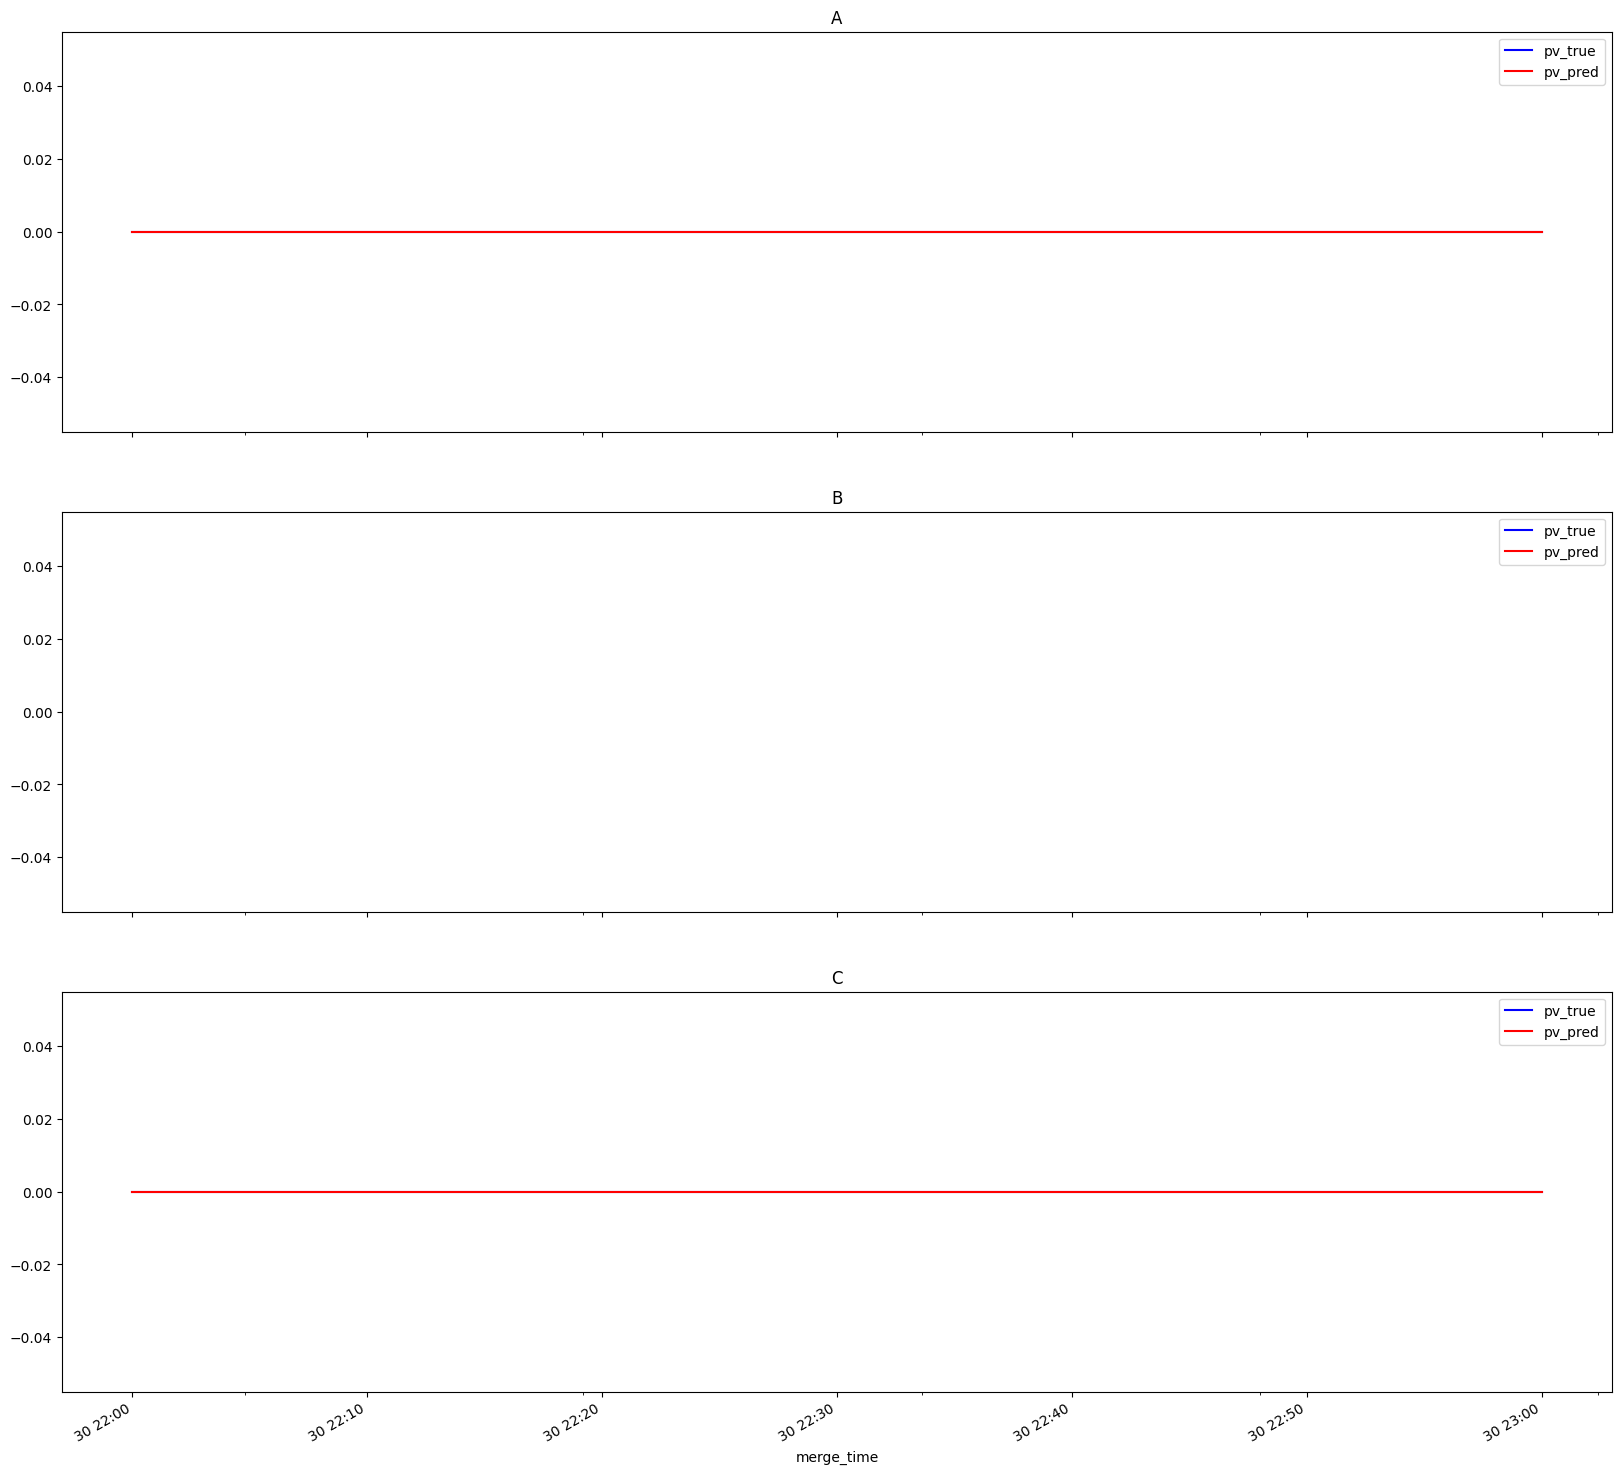

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(20, 20), sharex=True)

comparisonA.iloc[-400:][['merge_time', 'pv_true']].set_index('merge_time').plot(ax=axs[0], title='A', color='blue')
comparisonA.iloc[-400:][['merge_time', "pv_pred"]].set_index('merge_time').plot(ax=axs[0], title='A', color='red')
comparisonB.iloc[-400:][['merge_time', 'pv_true']].set_index('merge_time').plot(ax=axs[1], title='B', color='blue')
comparisonB.iloc[-400:][['merge_time', "pv_pred"]].set_index('merge_time').plot(ax=axs[1], title='B', color='red')
comparisonC.iloc[-400:][['merge_time', 'pv_true']].set_index('merge_time').plot(ax=axs[2], title='C', color='blue')
comparisonC.iloc[-400:][['merge_time', "pv_pred"]].set_index('merge_time').plot(ax=axs[2], title='C', color='red')

# Test

In [12]:
display(testset)
predictions = get_predictions(models, testset)
predictions.describe()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx_0.0,dew_or_rime:idx_1.0,dew_or_rime:idx_-1.0,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,fresh_snow_1h:cm,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,is_in_shadow:idx_00,is_in_shadow:idx_15,is_in_shadow:idx_30,is_in_shadow:idx_45,is_in_shadow:idx_60,msl_pressure:hPa,precip_5min:mm_00,precip_5min:mm_15,precip_5min:mm_30,precip_5min:mm_45,precip_5min:mm_60,precip_type_5min:idx_00_0.0,precip_type_5min:idx_00_1.0,precip_type_5min:idx_00_3.0,precip_type_5min:idx_00_2.0,precip_type_5min:idx_00_6.0,precip_type_5min:idx_00_5.0,precip_type_5min:idx_00_4.0,precip_type_5min:idx_15_0.0,precip_type_5min:idx_15_1.0,precip_type_5min:idx_15_3.0,precip_type_5min:idx_15_2.0,precip_type_5min:idx_15_4.0,precip_type_5min:idx_15_5.0,precip_type_5min:idx_30_0.0,precip_type_5min:idx_30_1.0,precip_type_5min:idx_30_3.0,precip_type_5min:idx_30_2.0,precip_type_5min:idx_30_5.0,precip_type_5min:idx_45_0.0,precip_type_5min:idx_45_1.0,precip_type_5min:idx_45_3.0,precip_type_5min:idx_45_2.0,precip_type_5min:idx_45_6.0,precip_type_5min:idx_45_5.0,precip_type_5min:idx_45_4.0,precip_type_5min:idx_60_0.0,precip_type_5min:idx_60_1.0,precip_type_5min:idx_60_3.0,precip_type_5min:idx_60_2.0,precip_type_5min:idx_60_6.0,precip_type_5min:idx_60_5.0,precip_type_5min:idx_60_4.0,prob_rime:p,relative_humidity_1000hPa:p,snow_density:kgm3_nan,snow_density:kgm3_250.0,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_u_10m:ms,wind_speed_v_10m:ms,location_A,location_B,location_C
88807,1.596365,1.2868,0.000000,0.000000,1,0,0,3.543818,0.000000,0.000000,0.000000,0.000000,2.120811,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,5.287767,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,5.620024,0,0,0.0,0.0,0.0,0.0,1.428300,1.408376,1.382815,1.351831,1.315189,-0.491922,-0.476294,-0.456083,-0.431441,-0.402341,2.408272,2.133965,1.673144,0.747469,1.786276,1,0,0
88808,1.574193,1.2856,0.000000,0.000000,1,0,0,3.508732,0.000000,0.000000,0.000000,0.000000,2.353675,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,5.249583,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,5.580811,0,0,0.0,0.0,0.0,0.0,1.315160,1.273951,1.228150,1.178086,1.123634,-0.402309,-0.368984,-0.331605,-0.290240,-0.245109,2.408272,2.368273,1.655216,0.682784,1.754187,1,0,0
88809,1.529849,1.2834,0.000000,0.000000,1,0,0,3.450254,0.000000,0.000000,0.000000,0.000000,2.488154,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,5.212927,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,5.433764,0,0,0.0,0.0,0.0,0.0,1.123610,1.065779,1.004627,0.940410,0.873112,-0.245089,-0.196372,-0.144312,-0.089091,-0.030984,2.417422,2.503587,1.769919,0.618100,1.711402,1,0,0
88810,1.478115,1.2820,0.071790,0.077663,1,0,0,3.388849,0.225880,0.259273,0.095634,0.048339,1.938594,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,5.173214,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,5.286716,0,0,0.0,0.0,0.0,0.0,0.873093,0.803494,0.731628,0.657690,0.581677,-0.030982,0.029788,0.092934,0.158239,0.225320,2.423515,1.950619,1.953616,0.510292,1.679313,1,0,0
88811,1.448553,1.2806,0.385530,0.390221,1,0,0,3.359612,0.865164,0.872225,0.506862,0.304760,2.003797,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5.141140,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,5.178881,0,0,0.0,0.0,0.0,0.0,0.581664,0.504118,0.425054,0.344586,0.262773,0.225301,0.293992,0.363875,0.434799,0.506283,2.429613,2.016225,1.981843,0.467168,1.625832,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/997855954.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X, verbose=0)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/997855954.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X, verbose=0)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_18980/997855954.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

count    2160.000000
mean      570.379028
std       985.763306
min         0.000000
25%         9.238873
50%       192.968475
75%       638.538452
max      5037.208496
dtype: float64

# Write testfiles

In [13]:
test_preds = pd.read_csv("sample_submission.csv")
test_preds["prediction"] = predictions.reset_index(drop=True)
test_preds.to_csv("ModelInterpretation_Magnus_B_Data_fix.csv", index=False)

In [14]:
display(test_preds)

,id,prediction
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,54.377586
4,4,361.682098
...,...,...
2155,2155,37.607166
2156,2156,10.389954
2157,2157,0.000000
2158,2158,0.000000
